### Download Data

In [1]:
import pandas as pd
import numpy as np
# read data to pandas frame
url = 'https://raw.githubusercontent.com/Dr-Ning-An/Deep-Learning-with-Keras/main/FixedBeam/FixedBeamData.csv'
data = pd.read_csv(url)
data.shape
# print(data.head(5))

(5000, 4)

In [2]:
n = 1000; # data size

In [3]:
inputs = data.iloc[:, 0:2][0:n] # read the first two columns n size data as inputs
# Normalize the inputs
inputs_norm = (inputs - inputs.mean()) / inputs.std()
n_inputs_norm = inputs_norm.shape[1]
print(inputs_norm.head(5))
outputs = data.iloc[:, 2:4][0:n] # read the last two columns n size data as inputs
# Normalize the outputs
outputs_norm = (outputs - outputs.mean()) / outputs.std()
n_outputs_norm = outputs_norm.shape[1]
print(outputs_norm.head(5))

   Coordinate x [m]  Distributed load q [kN/m]
0         -1.454237                  -1.547295
1          0.909583                   1.384380
2          1.599804                   1.446492
3          1.418131                  -0.169104
4         -1.290455                   0.634898
   Displacement u [m]  Curvature kappa [m-1]
0            1.225377              -0.647131
1           -0.503402               0.244706
2            1.289010              -2.477319
3            1.107871              -1.074265
4            0.744695              -0.835861


In [4]:
from sklearn.model_selection import train_test_split
# Randomly split the data into a training and test sets by holding 30% of the data for testing.
inputs_norm_train, inputs_norm_test, outputs_norm_train, outputs_norm_test = \
    train_test_split(inputs_norm, outputs_norm, test_size = 0.3, random_state=0)

In [5]:
import keras
from keras.layers import Dense
import tensorflow as tf

# define regression model using Functional API
def build_model():
    # create model
    inputs = tf.keras.Input(shape=(n_inputs_norm,), dtype=tf.float64)
    dense1 = Dense(20, activation='tanh')(inputs)
    dense2 = Dense(20, activation='tanh')(dense1)
    dense3 = Dense(20, activation='tanh')(dense2)
    outputs = Dense(n_outputs_norm)(dense3)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [6]:
# build the model
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 2)                 42        
                                                                 
Total params: 942
Trainable params: 942
Non-trainable params: 0
_________________________________________________________________


In [7]:
optimizer = tf.keras.optimizers.Adam()

In [8]:
BATCH_SIZE = 60
EPOCHS = 1000

In [9]:
dataset = tf.data.Dataset.from_tensor_slices((inputs_norm_train, outputs_norm_train))
dataset = dataset.batch(BATCH_SIZE)

### Chain rule

$\frac{d^2u_{norm}}{dx_{norm}^2}$ could be obtained by calculating the gradient of neural network output with respect to input, we then solve $\frac{d^2u}{dx^2}$ by using the chain rule.

$x_{norm} = (x - \bar{x})/\sigma_{x}$ 

$u_{norm} = (u - \bar{u})/\sigma_{u}$

where $x_{norm}$ and $u_{norm}$ denote the normalized data, $x$ and $u$ represent the naive data, $\bar{x}$ and $\bar{u}$ denote the mean of the data, and $\sigma_{x}$ and $\sigma_{u}$ denote the standard deviation of the data.

$\frac{d^2u}{dx^2} = \frac{d^2u}{du_{norm}^2} (\frac{du_{norm}}{dx})^2 + \frac{du}{du_{norm}} \frac{d^2u_{norm}}{dx^2} $

$ \quad \quad = \frac{d^2u}{du_{norm}^2} (\frac{du_{norm}}{dx_{norm}} \frac{dx_{norm}}{dx})^2 + \frac{du}{du_{norm}} \cdot [\frac{d^2u_{norm}}{dx_{norm}^2} (\frac{dx_{norm}}{dx})^2 + \frac{du_{norm}}{dx_{norm}} \frac{d^2x_{norm}}{dx^2}]$

$\quad \quad = 0 + \frac{du}{du_{norm}} \cdot [\frac{d^2u_{norm}}{dx_{norm}^2} (\frac{dx_{norm}}{dx})^2 + 0 ]$

$\quad \quad = \frac{du}{du_{norm}} \cdot \frac{d^2u_{norm}}{dx_{norm}^2} \cdot (\frac{dx_{norm}}{dx})^2 $

where $\frac{du}{du_{norm}} = \sigma_{u}$ is the standard deviation of $u$ data and $\frac{dx_{norm}}{dx} = \frac{1}{\sigma_{x}}$ and $\sigma_{x}$ is the standard deviation of $x$ data.

In [10]:
def PGNN(x_norm, q_norm):
    x_norm = tf.Variable(x_norm)
    q_norm = tf.Variable(q_norm)
    with tf.GradientTape() as g:
      g.watch(x_norm)
      with tf.GradientTape() as gg:
        gg.watch(x_norm)
        outputs_norm_pred = tf.cast(model(tf.stack([x_norm,q_norm], axis=1)), tf.float64)
        u_norm = outputs_norm_pred[:,0]
      du_norm_dx_norm = gg.gradient(u_norm, x_norm) 
    d2u_norm_dx_norm2 = g.gradient(du_norm_dx_norm, x_norm) 

    # Chain rule
    du_du_norm = outputs.std()[0]
    dx_norm_dx = 1/inputs.std()[0]
    d2u_dx2 =  du_du_norm *  d2u_norm_dx_norm2 * dx_norm_dx**2

    kappa_norm = outputs_norm_pred[:,1]
    kappa = kappa_norm * outputs.std()[1] + outputs.mean()[1]
    
    residual = d2u_dx2 - kappa

    return residual

In [11]:
def train_step(inputs, outputs):
    with tf.GradientTape() as tape:
        outputs_pred = tf.cast(model(inputs), tf.float64)
        residual = PGNN(inputs[:,0],inputs[:,1])
        loss1 = tf.losses.MeanSquaredError()(outputs, outputs_pred) 
        loss2 = tf.reduce_mean(tf.square(residual))
        loss = loss1 + loss2

    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

loss_hist = []
for epoch in range(EPOCHS):
    ep_loss = []
    for step, (inputs_norm_train_batch, outputs_norm_train_batch) in enumerate(dataset):
        loss_i = train_step(inputs_norm_train_batch, outputs_norm_train_batch)
        ep_loss.append(loss_i)

    if epoch % 1 == 0:
        print(f"Epoch {epoch} Loss: {tf.reduce_mean(ep_loss)}")

Epoch 0 Loss: 0.9690413296841491
Epoch 1 Loss: 0.9295972120342362
Epoch 2 Loss: 0.899739778169136
Epoch 3 Loss: 0.8634452583179518
Epoch 4 Loss: 0.8178279881112281
Epoch 5 Loss: 0.761859613233819
Epoch 6 Loss: 0.6964578275430595
Epoch 7 Loss: 0.6233314729081549
Epoch 8 Loss: 0.5443535767054128
Epoch 9 Loss: 0.46213305124303683
Epoch 10 Loss: 0.38058792395949137
Epoch 11 Loss: 0.30455973108982387
Epoch 12 Loss: 0.2384241982442127
Epoch 13 Loss: 0.18503482274579885
Epoch 14 Loss: 0.14506828256573495
Epoch 15 Loss: 0.11690900818913304
Epoch 16 Loss: 0.09746163275953353
Epoch 17 Loss: 0.08354045061917008
Epoch 18 Loss: 0.07283682647181193
Epoch 19 Loss: 0.06400296048765486
Epoch 20 Loss: 0.056390302481702015
Epoch 21 Loss: 0.049769637870584554
Epoch 22 Loss: 0.04409490052876939
Epoch 23 Loss: 0.03934907806433267
Epoch 24 Loss: 0.0354734157477293
Epoch 25 Loss: 0.0323561761910171
Epoch 26 Loss: 0.02985561406685701
Epoch 27 Loss: 0.02783104303719543
Epoch 28 Loss: 0.026164187882737177
Epoch 

In [12]:
test_data = outputs_norm_test * outputs.std() + outputs.mean()
print(test_data)
test_data_disp = test_data.to_numpy()[:,0]
test_data_kappa = test_data.to_numpy()[:,1]

     Displacement u [m]  Curvature kappa [m-1]
993       -1.373861e-05           4.245900e-07
859       -2.800103e-05           4.442457e-06
298       -1.490108e-05           3.009846e-07
553       -2.047168e-08          -8.608962e-06
672       -3.259385e-05           4.974724e-06
..                  ...                    ...
167       -1.988783e-06          -4.455945e-06
998       -1.846749e-05           2.057044e-06
984       -1.218423e-05           9.053289e-07
491       -4.836229e-06          -1.128942e-06
10        -1.401570e-05          -1.128858e-06

[300 rows x 2 columns]


In [13]:
pred_data_norm = model.predict(inputs_norm_test)
pred_data_norm_df = pd.DataFrame(pred_data_norm, columns = ['Displacement u [m]','Curvature kappa [m-1]'])
pred_data_df = pred_data_norm_df * outputs.std() + outputs.mean()
print(pred_data_df)
pred_data_disp = pred_data_df.to_numpy()[:,0]
pred_data_kappa = pred_data_df.to_numpy()[:,1]

10/10 [==============================] - 0s 2ms/step
     Displacement u [m]  Curvature kappa [m-1]
0         -1.382357e-05           4.477083e-07
1         -2.800834e-05           4.462159e-06
2         -1.500037e-05           3.280007e-07
3          2.409384e-07          -8.613615e-06
4         -3.254322e-05           4.972873e-06
..                  ...                    ...
295       -2.031039e-06          -4.399176e-06
296       -1.844358e-05           2.036530e-06
297       -1.217507e-05           8.896098e-07
298       -4.906037e-06          -1.092847e-06
299       -1.412885e-05          -1.058265e-06

[300 rows x 2 columns]


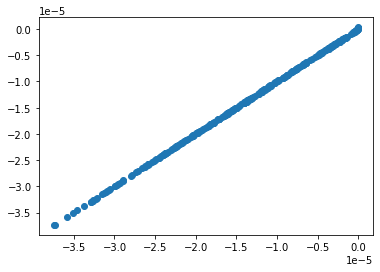

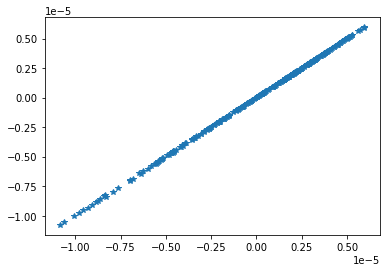

In [14]:
# Evaluate the mdoel on the test data and compare the error between predictions and true data
import matplotlib.pyplot as plt
plt.plot(test_data_disp, pred_data_disp, 'o')
plt.show()
plt.plot(test_data_kappa, pred_data_kappa, '*')
plt.show()

In [15]:
import tensorflow as tf
def F_model(x_norm,q_norm):
    x_norm = tf.Variable(x_norm)
    q_norm = tf.Variable(q_norm)
    with tf.GradientTape() as g:
      g.watch(x_norm)
      with tf.GradientTape() as gg:
        gg.watch(x_norm)
        u_norm = model(tf.stack([x_norm,q_norm], axis=1))[:,0]
      du_norm_dx_norm = gg.gradient(u_norm, x_norm)  
    d2u_norm_dx_norm2 = g.gradient(du_norm_dx_norm, x_norm)  

    # Chain rule
    du_du_norm = outputs.std()[0]
    dx_norm_dx = 1/inputs.std()[0]
    d2u_dx2 =  du_du_norm *  d2u_norm_dx_norm2 * dx_norm_dx**2

    u = u_norm * outputs.std()[0] + outputs.mean()[0]

    return u, d2u_dx2

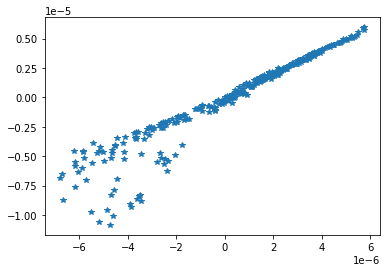

In [16]:
x_norm = inputs_norm_test.to_numpy()[:,0]
q_norm = inputs_norm_test.to_numpy()[:,1]
[u, d2u_dx2] = F_model(x_norm, q_norm)
# print(d2u_dx2)
plt.plot(d2u_dx2, test_data_kappa, '*')
plt.show()